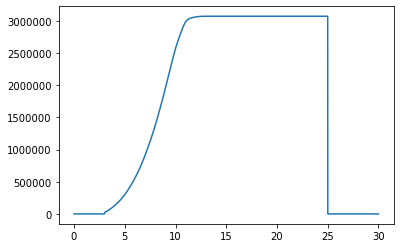

In [197]:
import pandas as pd
import numpy as np
import math
from scipy.stats import weibull_min, invweibull, uniform, norm
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

# Create the P function from matlab
data = np.loadtxt("powermat.csv", delimiter=",")
x = np.arange(0,30,0.001)
P = interp1d(x,data, fill_value="extrapolate")

# Creating lambda function allowing faster calculations
calculate_power = lambda x: P(x)
_ = plt.plot(x,P(x))

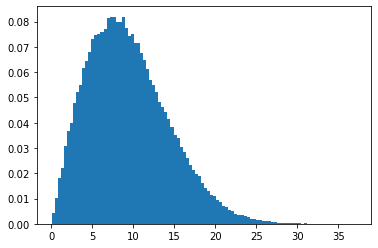

In [167]:
# Setting the parameters, this is for january
param = {
    "jan" : [10.6, 2.0],
    "feb" : [9.7, 2.0],
    "mar" : [9.2, 2.0],
    "apr" : [8.0, 1.9],
    "may" : [7.8, 1.9],
    "jun" : [8.1, 1.9],
    "jul" : [7.8, 1.9],
    "aug" : [8.1, 1.9],
    "sep" : [9.1, 2.0],
    "oct" : [9.9, 1.9],
    "nov" : [10.6, 2.0],
    "dec" : [10.6, 2.0]
}
[lam, k] = param["jan"]
n = 10**5

# Creating the wind distribution for a month
wind_distribution =  weibull_min(k,loc=0, scale=lam)

# Generate wind
wind = wind_distribution.rvs(size=n)
_ = plt.hist(wind, bins=100, density=True)

Mean: 1733601.5311338867 ± 7583.319945735693, Var: 1496947662416.5137


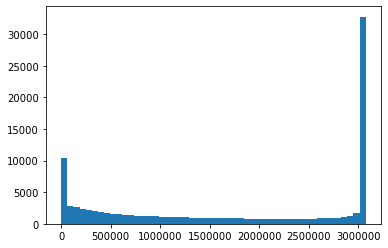

In [169]:
# A) Expected amount of power

# Calculated power from the generated wind
power = P(wind)
hist = plt.hist(power, bins=50)

# Calculating mean, variance and the confidence interval for the mean
mean = np.mean(power)
var = np.var(power)
confidence_interval = 1.96*np.sqrt(var/n)

print(f'Mean: {mean} ± {confidence_interval}, Var: {var}')

Mean: 1736507.206531282 ± 6600.753751902986, Var: 1134161549699.6394


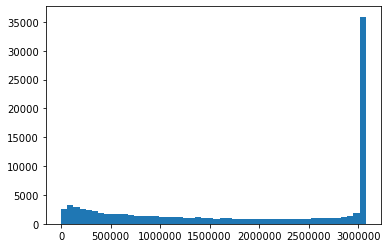

In [170]:
# A) Expected amount of power, truncated version

# Calculating F(3) and F(25) for the distribution for the wind
F_min = wind_distribution.cdf(3)
F_max = wind_distribution.cdf(25)

# Generate uniform data
u = uniform.rvs(size=n)

# Fix condition to U
u = ((F_max-F_min)*u + F_min)

# Run u through inverse of weibull 
wind_truncated = wind_distribution.ppf(u)

# Calculated the power for the truncated wind
power_trunc = calculate_power(wind_truncated)
hist = plt.hist(power_trunc, bins=50)

# Calculating mean, variance and the confidence interval for the mean
mean = np.mean(power_trunc)*(F_max-F_min)
var = np.var(power_trunc)*((F_max-F_min)**2)
confidence_intervall = 1.96*np.sqrt(var/n)

print(f'Mean: {mean} ± {confidence_intervall}, Var: {var}')

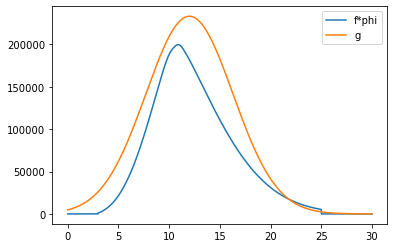

In [193]:
x = np.linspace(0,30, num=n)


h = lambda x: P(x)*wind_distribution.pdf(x)

# Selecting g as a normal distribution
my = 12
sigma2 = 4.3 
g_scale = 10**6.4
g_dist = norm(my, sigma2)
g = lambda x: g_dist.pdf(x)

plt.plot(x,h(x), label='f*phi')
plt.plot(x, g_scale*g(x), label = 'g')
_ = plt.legend()

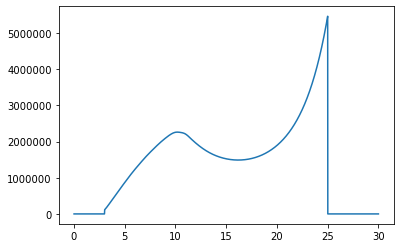

In [172]:
#Checking if the chosen instrumental density is stable
_ = plt.plot(x, h(x)/g(x))

In [173]:
#Draw X from g
X = g_dist.rvs(size=n)

#function to evaluate
s = lambda x: h(x)/g(x)

#Calculate variance
mean = np.mean(s(X))
var = np.var(s(X))
confidence_interval = 1.96*np.sqrt(var/n)
print(f'Mean: {mean} ± {confidence_interval}, Var: {var}')

Mean: 1731969.7079626743 ± 2940.917304674141, Var: 225140425680.2326


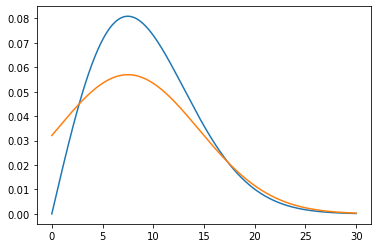

In [174]:
x = np.linspace(0,30, num=n)

# Selecting g as a normal distribution with my = 7.5 and sigma = 5
g_dist = norm(7.5, 7)

# Function to calculate for each drawn g
s = lambda x: P(x)*wind_distribution.pdf(x)/g_dist.pdf(x)

plt.plot(x,wind_distribution.pdf(x))
plt.plot(x, g_dist.pdf(x))
#plt.plot(x, s(x))

In [96]:
# Draw n samples from g
samples_from_g = g_dist.rvs(size=n)

# Calculated the weighted sample
weighted_samples = s(samples_from_g)

# Calculating mean, variance and the confidence interval for the mean
mean = np.mean(weighted_samples)
var = np.var(weighted_samples)
confidence_intervall = 1.96*np.sqrt(var/n)

print(f'Mean: {mean} ± {confidence_intervall}, Var: {var}')

Mean: 1733658.448882098 ± 3964.4154579419414, Var: 409115731027.93146


1743431.035069968
1741671.4649300317
1962021032814.286
1962742636927.5999
1742551.25
Mean: 1748798.625 ± 5051.753195618287, Var: 664312014510.6094


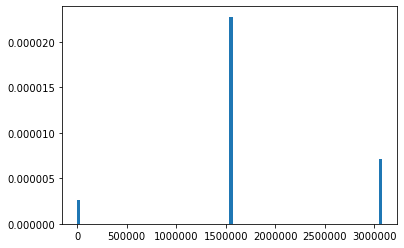

In [207]:
# Letting V = P, and V' = Max(P) - P, unsure if this has increased complexity
V_1 = P
V_2 = lambda x: np.where((x >= 3) & (x <= 13), -P(x) + np.max(P(x)), P(x))
W = lambda x: (V_1(x) + V_2(x))/2

#plt.plot(x, V_1(x))
#plt.plot(x, V_2(x))
#plt.plot(x, W(x))

print(np.mean(V_1(x)))
print(np.mean(V_2(x)))
print(np.var(V_1(x)))
print(np.var(V_2(x)))
print(np.mean(W(x)))

power_as = W(wind)
hist = plt.hist(power_as, density=True, bins=100)

# Calculating mean, variance and the confidence interval for the mean
mean = np.mean(power_as)
var = np.var(power_as)
confidence_intervall = 1.96*np.sqrt(var/n)

print(f'Mean: {mean} ± {confidence_intervall}, Var: {var}')

In [128]:
# Probability that the turbine delivers power
print(f'Prob for delivering power: {(F_max - F_min)*100}%')

Prob for delivering power: 91.91850832071029%


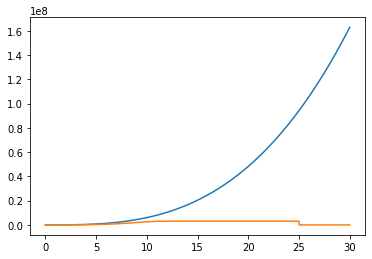

In [202]:
Ptot = lambda v: 1/2*1.225*math.pi*112**2/4*v**3

plt.plot(x,Ptot(x))
plt.plot(x,P(x))

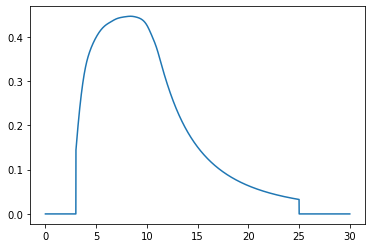

In [205]:
with np.errstate(divide='ignore', invalid='ignore'):
    _ = plt.plot(x, P(x)/Ptot(x))

In [ ]:
# Antar att man ska sampla från Power curve?